<a href="https://colab.research.google.com/github/Daprosero/Procesamiento_Lenguaje_Natural/blob/main/1.%20Conceptos%20Preliminares/1.6.%20Modelos_Secuenciales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://www.funcionpublica.gov.co/documents/d/guest/logo-universidad-nacional)



# **Modelos_Secuenciales**
### Departamento de Ingeniería Eléctrica, Electrónica y Computación
#### Universidad Nacional de Colombia - Sede Manizales

#### Profesor: Diego A. Pérez

# **Prepare Data**

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
import pandas as pd

# Load the dataset from a URL
url = "https://raw.githubusercontent.com/juacardonahe/Curso_NLP/refs/heads/main/data/SMSSpamCollection/SMSSpamCollection"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
print(df.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


# **Explore the Data**
Next, we explore the dataset to understand its structure, including the number of entries and the distribution of spam vs. ham messages. This helps us identify potential issues like class imbalance.

In [ ]:
tf.random.set_seed(42)

In [ ]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

# Check the distribution of labels
print("\nClass Distribution:")
print(df['label'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


# **Preprocess the Data**
Preprocessing converts the raw text into a format suitable for the LSTM model. This includes encoding labels, calculating an appropriate sequence length, splitting the data, tokenizing text, padding sequences, and handling class imbalance with weights.

In [ ]:
# Encode labels: ham -> 0, spam -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Calculate max_length based on the 95th percentile of message lengths
df['message_length'] = df['message'].apply(lambda x: len(x.split()))
max_length = int(df['message_length'].quantile(0.95))
print(f"Max sequence length (95th percentile): {max_length}")

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train) # Convert list to numpy array
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")
X_train_pad.shape

Max sequence length (95th percentile): 33
Vocabulary size: 7954
Class weights: {0: np.float64(0.577481212749417), 1: np.float64(3.7265886287625416)}


(4457, 33)

# RNN
We define the RNN model architecture using Keras. It includes an embedding layer to convert words into vectors, an RNN layer to process sequences, a dropout layer to prevent overfitting, and a dense layer for classification.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

# Modelo con RNN (SimpleRNN)
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(SimpleRNN(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##**Compile the Model**
We compile the model by specifying the loss function (binary cross-entropy for binary classification), the optimizer (Adam), and the metric (accuracy) to monitor during training.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

##**Visualize Training Performance**
We plot the training and validation accuracy and loss over epochs to assess how well the model is learning and to check for overfitting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2,
                    class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6806 - loss: 0.5689 - val_accuracy: 0.9585 - val_loss: 0.1416
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9653 - loss: 0.1502 - val_accuracy: 0.8924 - val_loss: 0.2796
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9840 - loss: 0.0935 - val_accuracy: 0.9776 - val_loss: 0.0686
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9980 - loss: 0.0142 - val_accuracy: 0.9731 - val_loss: 0.1080
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9990 - loss: 0.0084 - val_accuracy: 0.9742 - val_loss: 0.0994
Epoch 6/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9765 - val_loss: 0.0957


##**Visualize Training Performance**
We plot the training and validation accuracy and loss over epochs to assess how well the model is learning and to check for overfitting.

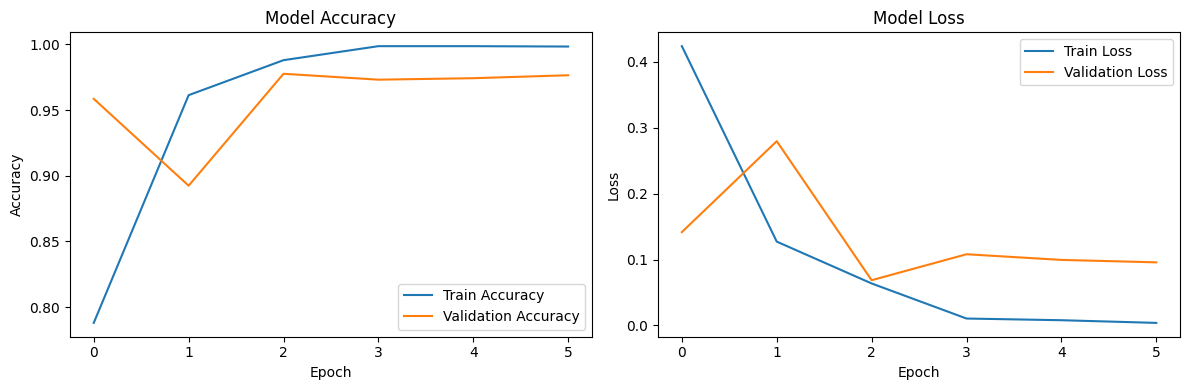

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

##**Evaluate the model**

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9776 - loss: 0.0809

Test Loss: 0.0791
Test Accuracy: 0.9758


##**Make predictions**
Finally, we create a function to classify new SMS messages and test it with example inputs, demonstrating the model's practical use.

In [ ]:
# Function to predict spam or ham
def predict_spam(message):
    seq = tokenizer.texts_to_sequences([message])
    pad_seq = pad_sequences(seq, maxlen=max_length)
    prediction = model.predict(pad_seq, verbose=0)
    return 'spam' if prediction[0] > 0.5 else 'ham'

# Test with example messages
example_messages = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now!",
    "Hey, are you free this weekend?"
]
for msg in example_messages:
    result = predict_spam(msg)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {result}")


Message: Congratulations! You've won a free ticket to the Bahamas. Call now!
Prediction: spam

Message: Hey, are you free this weekend?
Prediction: ham


# **LSTM Model**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2,
                    class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8395 - loss: 0.4863 - val_accuracy: 0.9742 - val_loss: 0.1323
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9759 - loss: 0.1003 - val_accuracy: 0.9832 - val_loss: 0.0692
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9894 - loss: 0.0490 - val_accuracy: 0.9809 - val_loss: 0.0732
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9973 - loss: 0.0122 - val_accuracy: 0.9821 - val_loss: 0.0737
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9975 - loss: 0.0088 - val_accuracy: 0.9821 - val_loss: 0.1164


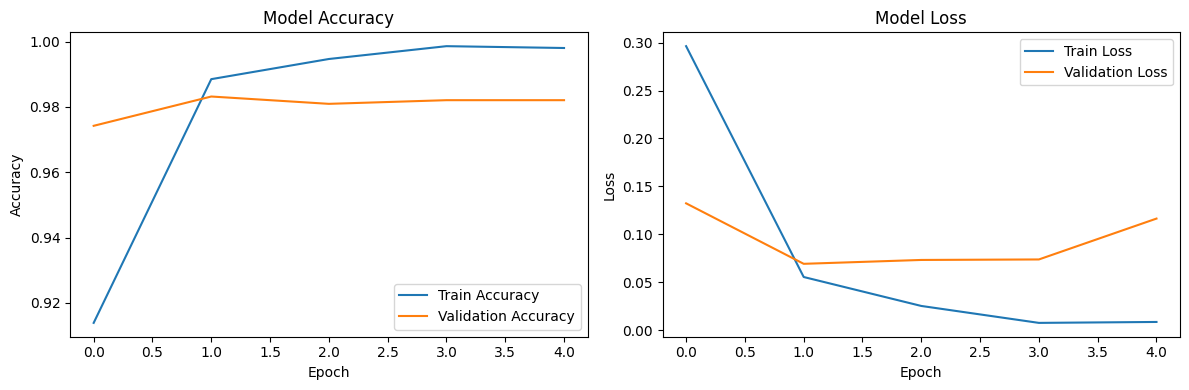

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9885 - loss: 0.0538

Test Loss: 0.0595
Test Accuracy: 0.9874


In [ ]:
# Function to predict spam or ham
def predict_spam(message):
    seq = tokenizer.texts_to_sequences([message])
    pad_seq = pad_sequences(seq, maxlen=max_length)
    prediction = model.predict(pad_seq, verbose=0)
    return 'spam' if prediction[0] > 0.5 else 'ham'

# Test with example messages
example_messages = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now!",
    "Hey, are you free this weekend?"
]
for msg in example_messages:
    result = predict_spam(msg)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {result}")


Message: Congratulations! You've won a free ticket to the Bahamas. Call now!
Prediction: spam

Message: Hey, are you free this weekend?
Prediction: ham


# GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Modelo con GRU
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2,
                    class_weight=class_weights, callbacks=[early_stopping])

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7712 - loss: 0.4834 - val_accuracy: 0.9765 - val_loss: 0.0727
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9783 - loss: 0.0778 - val_accuracy: 0.9832 - val_loss: 0.0675
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9955 - loss: 0.0173 - val_accuracy: 0.9843 - val_loss: 0.0789
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9821 - val_loss: 0.0973
Epoch 5/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 1.0000 - loss: 4.6223e-04 - val_accuracy: 0.9821 - val_loss: 0.1028


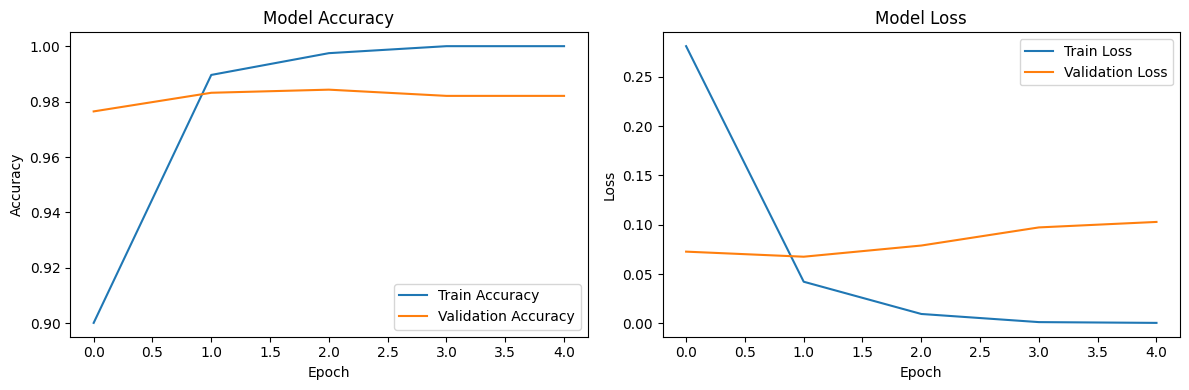

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9903 - loss: 0.0649

Test Loss: 0.0574
Test Accuracy: 0.9919


In [ ]:
# Function to predict spam or ham
def predict_spam(message):
    seq = tokenizer.texts_to_sequences([message])
    pad_seq = pad_sequences(seq, maxlen=max_length)
    prediction = model.predict(pad_seq, verbose=0)
    return 'spam' if prediction[0] > 0.5 else 'ham'

# Test with example messages
example_messages = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now!",
    "Hey, are you free this weekend?"
]
for msg in example_messages:
    result = predict_spam(msg)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {result}")


Message: Congratulations! You've won a free ticket to the Bahamas. Call now!
Prediction: spam

Message: Hey, are you free this weekend?
Prediction: ham
